# Creating Initial position file
###  The following code use Pylag to Create initial position file

### Required imports


In [7]:
#Required imports
from collections import namedtuple
import numpy as np
import datetime
from netCDF4 import Dataset
import configparser
from matplotlib import pyplot as plt
from cftime import num2pydate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure
from pylag.processing.utils import get_grid_bands

from pylag.processing.coordinate import utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zones_along_cord


## Creating initial Position file

In [25]:
# setting the initial position for lake 
import os
data_dir = '/home/samin/data/FVCOME_OUTPUT'.format(os.environ['HOME'])
from pylag.processing.coordinate import get_epsg_code, utm_from_lonlat, lonlat_from_utm, british_national_grid_to_lonlat
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group
from pylag.processing.input import create_initial_positions_file_multi_group

# keep a copy of cwd
cwd = os.getcwd()
# create a run directory  
simulation_dir = '/home/samin/data/FVCOME_OUTPUT/simulations/horon'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set 
group_id = 1
# Lat and lon coordiantes for the centre of the release zone

# Lake Huron west
#lat = 45.598943
#lon = 272
#lat = 42
#lon = -84.180371
#lat= 44.52993 
#lon = 271.98904

# Lake Huron Ausable Point
#at = 44.4821
#lon = 276.87

lat = 44.40658 
lon = 276.681187 + 0.1


# Convert to UTM coordinates
epsg_code = '4978'

#epsg_code = get_epsg_code(lon, lat)
easting, northing, _ = utm_from_lonlat([lon], [lat], epsg_code=epsg_code)

# Release zone radius (m)
radius =0.1

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 50

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Create input sub-directory
input_dir =  '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions_Ausable.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           surface_release_zone.get_eastings(),
                                           surface_release_zone.get_northings(),
                                           surface_release_zone.get_depths())

# Plot initial position file

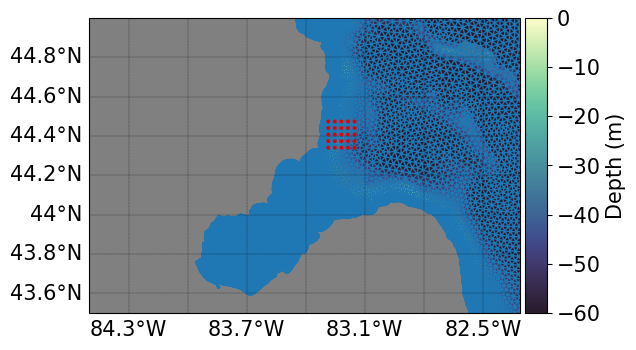

In [28]:
# Convert utm coords to degrees
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap

lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             surface_release_zone.get_northings(),
                             epsg_code=epsg_code)

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(15., 15.), projection=ccrs.PlateCarree(),
                       font_size=font_size, bg_color='gray')


#Grid metrics file name
grid_metrics_file_name = f"{input_dir}/grid_metrics_huron.nc"
# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
#extents = np.array([-84.10,-84.20, 45.58,45.65], dtype=float)
#extensts = np.array([-84,-813, 43,46], dtype=float)
#Lake Huron Ausable Point
extents = np.array([275.5,277.69, 43.5,45], dtype=float)

ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=cmap)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')
# save the initial positions figure
plt.savefig(f"{input_dir}/release_zone_Ausable_watershed.png")    
